In [1]:
# """
# VAR 분석 순서
# 1) Stationarity Test
# 2) 인과관계 검정 -> 변수 배열
# 3) 추정 -> 차수 결정 (정보기준 통해)
# 4) 예측: (1) 시계열값, (2) 충격반응분석
# 5) FEVD (어느 변수의 영향력이 큰지 판단)
# """

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [3]:
df = pd.read_csv('time_data\\var_data.csv', parse_dates=['date'], index_col='date')

In [4]:
df

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-01-01,1606.4,1608.3,47.5,36.9,37.4,26.9,32.3,23.1
1959-04-01,1637.0,1622.2,47.5,37.4,37.5,27.0,32.2,23.4
1959-07-01,1629.5,1636.2,48.7,37.6,37.6,27.1,32.4,23.4
1959-10-01,1643.4,1650.3,48.8,37.7,37.8,27.1,32.5,23.8
1960-01-01,1671.6,1664.6,49.1,37.8,37.8,27.2,32.4,23.8
...,...,...,...,...,...,...,...,...
1988-07-01,4042.7,3971.9,179.6,131.5,124.9,106.2,123.5,92.8
1988-10-01,4069.4,3995.8,181.3,133.3,126.2,107.3,124.9,92.9
1989-01-01,4106.8,4019.9,184.1,134.8,127.7,109.5,126.6,94.0


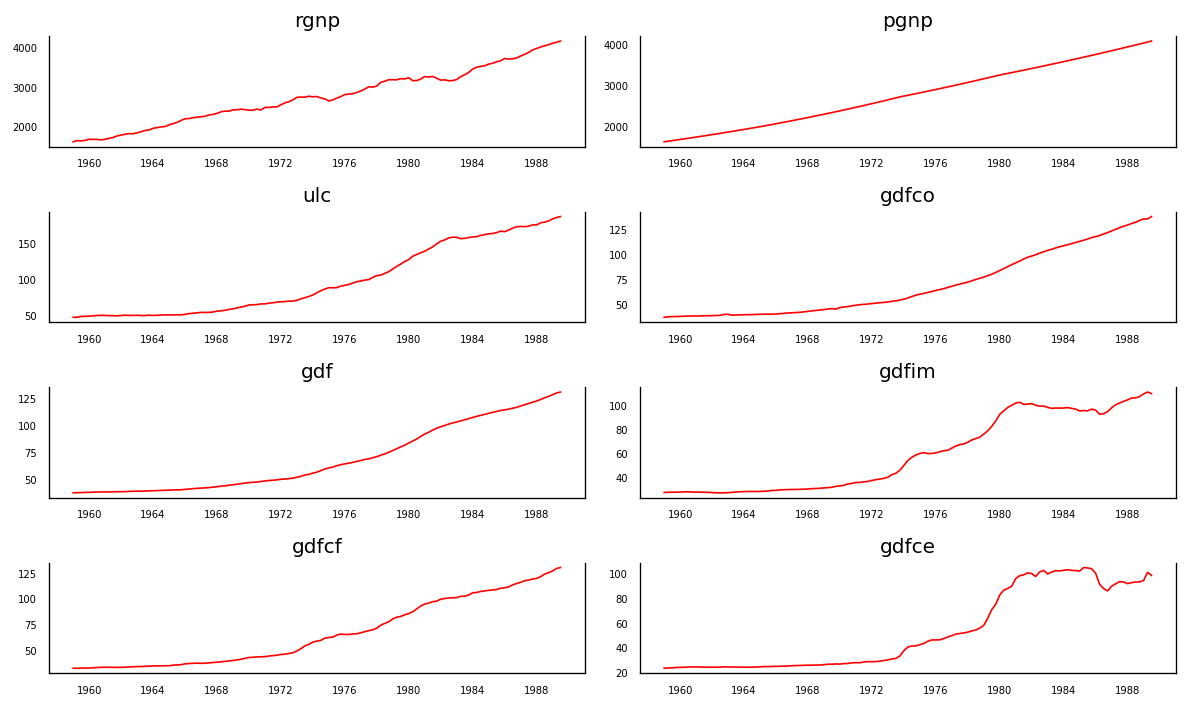

In [5]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()
plt.show()

In [6]:
# train, test split
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(119, 8)
(4, 8)


stationarity test

stationary test 1: ACF, PACF

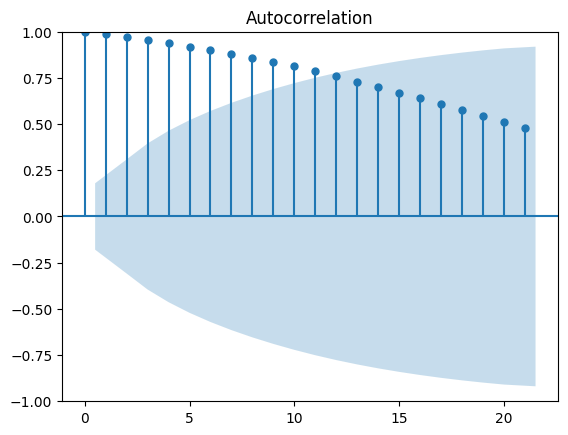

In [7]:
#stationarity check
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_train.gdfce)
plt.show()

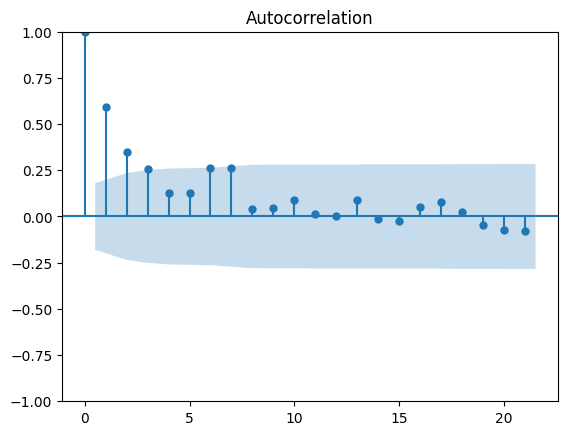

In [8]:
plot_acf(df_train.gdfce.diff().dropna())
plt.show()

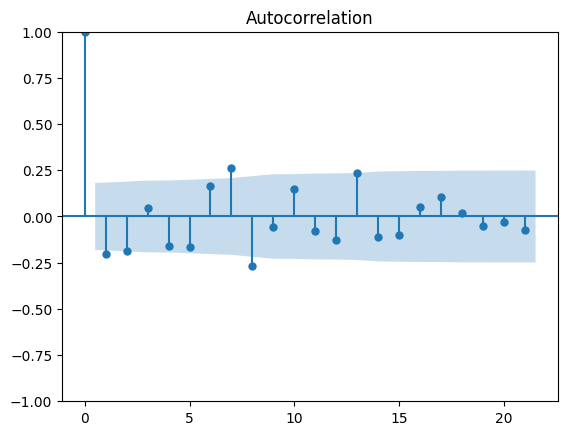

In [9]:
plot_acf(df_train.gdfce.diff().dropna().diff().dropna())
plt.show()

Stationary Check 2: adfuller

In [10]:
result = smt.adfuller(df_train.gdfce)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

#Non-stationary

ADF Statistic: -0.340157
p-value: 0.919621
Critical Test Statistics Values:
	1%: -3.491
	5%: -2.888
	10%: -2.581


In [11]:
result[1]

0.9196212658093701

In [12]:
def ad_fuller_test(df):
    for column in df.columns:
        if smt.adfuller(df[column])[1] < 0.05:
            print(f'{column}: stationary')
        else: print(f'{column}: not stationary')

In [13]:
ad_fuller_test(df_train)

rgnp: not stationary
pgnp: not stationary
ulc: not stationary
gdfco: not stationary
gdf: not stationary
gdfim: not stationary
gdfcf: not stationary
gdfce: not stationary


In [14]:
#1st difference
df_differenced = df_train.diff().dropna()

In [15]:
ad_fuller_test(df_differenced)

rgnp: stationary
pgnp: not stationary
ulc: stationary
gdfco: not stationary
gdf: not stationary
gdfim: stationary
gdfcf: not stationary
gdfce: stationary


In [16]:
# 2nd differencing
df_differenced = df_differenced.diff().dropna()
ad_fuller_test(df_differenced)

rgnp: stationary
pgnp: stationary
ulc: stationary
gdfco: stationary
gdf: stationary
gdfim: stationary
gdfcf: stationary
gdfce: stationary


granger causality test: 변수 배열

statsmodels VAR 모형의 경우 변수배열과 cholesky decomposition 결과가 같음

In [17]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_differenced, variables = df_differenced.columns)    

,rgnp_x,pgnp_x,ulc_x,gdfco_x,gdf_x,gdfim_x,gdfcf_x,gdfce_x
rgnp_y,1.0000,0.0310,0.0000,0.0167,0.0001,0.0076,0.0001,0.0187
pgnp_y,0.0032,1.0000,0.3454,0.1703,0.0069,0.0508,0.0447,0.0707
ulc_y,0.0000,0.0009,1.0000,0.4198,0.0000,0.0020,0.0005,0.0000
gdfco_y,0.2312,0.0819,0.0031,1.0000,0.0161,0.0048,0.1417,0.1022
gdf_y,0.0497,0.0000,0.0200,0.2388,1.0000,0.0004,0.0478,0.0000
gdfim_y,0.0900,0.0006,0.0140,0.4795,0.0000,1.0000,0.0001,0.0097
gdfcf_y,0.0277,0.0000,0.2692,0.5019,0.0476,0.0027,1.0000,0.0050
gdfce_y,0.0004,0.0675,0.0000,0.6230,0.0005,0.0000,0.0001,1.0000


In [18]:
F = grangercausalitytests(df_differenced[['rgnp', 'gdf']], maxlag=12)[12][0]['ssr_ftest'][0]
p_value = grangercausalitytests(df_differenced[['rgnp', 'gdf']], maxlag=12)[12][0]['ssr_ftest'][1]


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0160  , p=0.8994  , df_denom=113, df_num=1
ssr based chi2 test:   chi2=0.0165  , p=0.8979  , df=1
likelihood ratio test: chi2=0.0165  , p=0.8979  , df=1
parameter F test:         F=0.0160  , p=0.8994  , df_denom=113, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1360  , p=0.3248  , df_denom=110, df_num=2
ssr based chi2 test:   chi2=2.3752  , p=0.3050  , df=2
likelihood ratio test: chi2=2.3510  , p=0.3087  , df=2
parameter F test:         F=1.1360  , p=0.3248  , df_denom=110, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7275  , p=0.5378  , df_denom=107, df_num=3
ssr based chi2 test:   chi2=2.3252  , p=0.5077  , df=3
likelihood ratio test: chi2=2.3019  , p=0.5122  , df=3
parameter F test:         F=0.7275  , p=0.5378  , df_denom=107, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.2573  , p=0.0679  

In [19]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_ftest'
def grangers_causation_matrix_pvalue(data, variables, test='ssr_ftest', verbose=False):    

    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]

            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            lag_12_pvalue = p_values[-1]
            df.loc[r, c] = lag_12_pvalue
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

def grangers_causation_matrix_fvalue(data, variables, test='ssr_ftest', verbose=False):    

    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            f_values = [round(test_result[i+1][0][test][0],4) for i in range(maxlag)]

            if verbose: print(f'Y = {r}, X = {c}, P Values = {f_values}')
            lag_12_fvalue = f_values[-1]
            df.loc[r, c] = lag_12_fvalue
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix_fvalue(df_differenced, variables = df_differenced.columns)    

,rgnp_x,pgnp_x,ulc_x,gdfco_x,gdf_x,gdfim_x,gdfcf_x,gdfce_x
rgnp_y,-0.0000,1.4372,3.3571,1.5636,2.3992,1.7165,2.1658,1.5406
pgnp_y,1.8778,0.0000,0.7581,0.7169,1.6138,1.1279,1.1939,1.0391
ulc_y,3.2740,2.0989,0.0000,0.6531,3.3856,1.9669,1.9666,3.5153
gdfco_y,0.8743,0.9527,1.8730,0.0000,1.5323,1.7474,1.0475,1.0459
gdf_y,1.2033,3.6035,1.5268,0.5758,-0.0000,2.1272,1.0383,2.0956
gdfim_y,0.8654,2.1488,1.5133,0.5402,3.0195,0.0000,2.5622,1.6701
gdfcf_y,1.2762,3.4988,0.4841,0.5142,1.3459,1.7455,-0.0000,1.6272
gdfce_y,1.4050,1.1228,1.7892,0.3357,2.0954,2.6695,2.5938,0.0000


In [20]:
# Granger 인과관계 검정의 경우 시차 길이에 따라 인과관계 검정 결과가 달리 나타날 수 있음
# 인과관계 검정 결과가 시차에 민감한 경우 짧은 시차보다는 긴 시차를 적용하는 것이 적절

In [21]:
grangers_causation_matrix_fvalue(df_differenced, variables = df_differenced.columns)

,rgnp_x,pgnp_x,ulc_x,gdfco_x,gdf_x,gdfim_x,gdfcf_x,gdfce_x
rgnp_y,-0.0000,1.4372,3.3571,1.5636,2.3992,1.7165,2.1658,1.5406
pgnp_y,1.8778,0.0000,0.7581,0.7169,1.6138,1.1279,1.1939,1.0391
ulc_y,3.2740,2.0989,0.0000,0.6531,3.3856,1.9669,1.9666,3.5153
gdfco_y,0.8743,0.9527,1.8730,0.0000,1.5323,1.7474,1.0475,1.0459
gdf_y,1.2033,3.6035,1.5268,0.5758,-0.0000,2.1272,1.0383,2.0956
gdfim_y,0.8654,2.1488,1.5133,0.5402,3.0195,0.0000,2.5622,1.6701
gdfcf_y,1.2762,3.4988,0.4841,0.5142,1.3459,1.7455,-0.0000,1.6272
gdfce_y,1.4050,1.1228,1.7892,0.3357,2.0954,2.6695,2.5938,0.0000


In [22]:
grangers_causation_matrix_pvalue(df_differenced, variables = df_differenced.columns)

,rgnp_x,pgnp_x,ulc_x,gdfco_x,gdf_x,gdfim_x,gdfcf_x,gdfce_x
rgnp_y,1.0000,0.1667,0.0005,0.1195,0.0105,0.0785,0.0213,0.1271
pgnp_y,0.0496,1.0000,0.6907,0.7308,0.1043,0.3500,0.3019,0.4224
ulc_y,0.0007,0.0260,1.0000,0.7903,0.0005,0.0383,0.0383,0.0003
gdfco_y,0.5757,0.5002,0.0503,1.0000,0.1299,0.0720,0.4152,0.4166
gdf_y,0.2955,0.0003,0.1319,0.8554,1.0000,0.0239,0.4231,0.0262
gdfim_y,0.5844,0.0224,0.1367,0.8820,0.0016,1.0000,0.0064,0.0893
gdfcf_y,0.2490,0.0004,0.9185,0.8997,0.2100,0.0724,1.0000,0.1006
gdfce_y,0.1811,0.3540,0.0640,0.9801,0.0262,0.0046,0.0058,1.0000


In [23]:
# test
# grangercausalitytests(df_differenced[['rgnp', 'ulc']], maxlag=12)
# # lag 12: ssr based F test:         F=3.3571  , p=0.0005  , df_denom=80, df_num=12

차수 결정 (정보기준 통해)

In [24]:
model = smt.VAR(df_differenced)

c:\Users\SH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [25]:
model.select_order(maxlags=12).summary()

,AIC,BIC,FPE,HQIC
0,-0.07898,0.1232,0.9241,0.002961
1,-0.5721,1.248,0.5662,0.1653
2,-0.8256,2.612,0.4482,0.5674
3,-1.007,4.048,0.3937,1.042
4,-1.255,5.418,0.3399,1.449
5,-1.230,7.060,0.4147,2.129
6,-1.739,8.169,0.3286,2.276
7,-2.142,9.384,0.3340,2.528
8,-2.964,10.18,0.2744,2.362
9,-4.562,10.20,0.1413,1.420


In [26]:
model = smt.VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

#AIC를 기준으로 선택할 경우: LAG ORDER 4가 바람직해보임

Lag Order = 1
AIC :  -1.3679402315450673
BIC :  0.3411847146588829
FPE :  0.2552682517347195
HQIC:  -0.6741331335699563 

Lag Order = 2
AIC :  -1.6212373944478222
BIC :  1.6249432095295866
FPE :  0.20113494371371424
HQIC:  -0.30362888267959054 

Lag Order = 3
AIC :  -1.76580083870128
BIC :  3.0345473163767824
FPE :  0.18125103746164348
HQIC:  0.18239143783963208 

Lag Order = 4
AIC :  -2.000735164470318
BIC :  4.3712151376540875
FPE :  0.15556966521481097
HQIC:  0.5849359332771069 

Lag Order = 5
AIC :  -1.961953560836398
BIC :  5.999364562242093
FPE :  0.1869279438911484
HQIC:  1.2682063311783303 

Lag Order = 6
AIC :  -2.330338652482907
BIC :  7.238452689088579
FPE :  0.16380374017443636
HQIC:  1.5514371669548055 

Lag Order = 7
AIC :  -2.5923313523471254
BIC :  8.602387254937799
FPE :  0.18238685837154206
HQIC:  1.9483069621146587 

Lag Order = 8
AIC :  -3.317261976458207
BIC :  9.522195810323028
FPE :  0.1557316324820906
HQIC:  1.8896071386220967 

Lag Order = 9
AIC :  -4.804763125

c:\Users\SH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [27]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 18, Dec, 2022
Time:                     16:47:30
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    4.37122
Nobs:                     113.000    HQIC:                  0.584936
Log likelihood:          -905.679    FPE:                   0.155570
AIC:                     -2.00074    Det(Omega_mle):       0.0200322
--------------------------------------------------------------------
Results for equation rgnp
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            2.430021         2.677505            0.908           0.364
L1.rgnp         -0.750066         0.159023           -4.717           0.000
L1.pgnp         -0.095621         4.938865           -0.019           0.985
L1.ul

모델 및 계수 해석

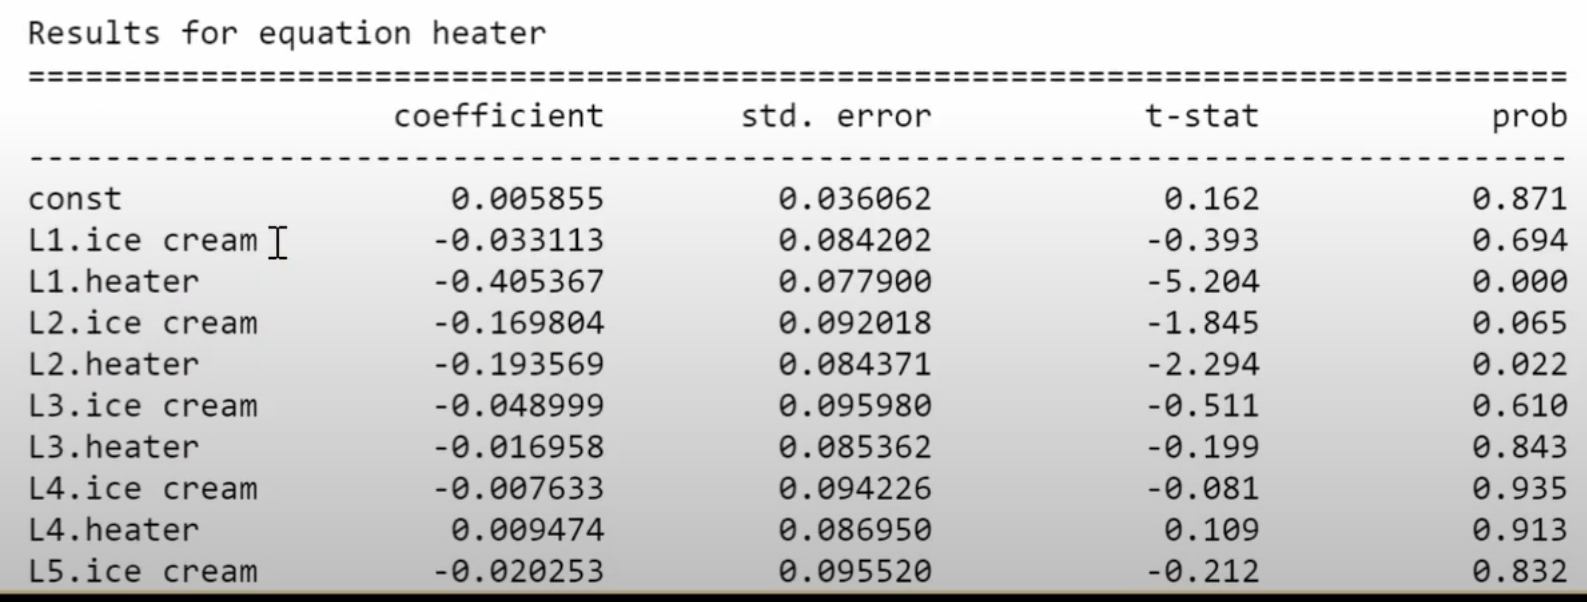

In [28]:
from IPython.display import Image
Image('images\\90.png')

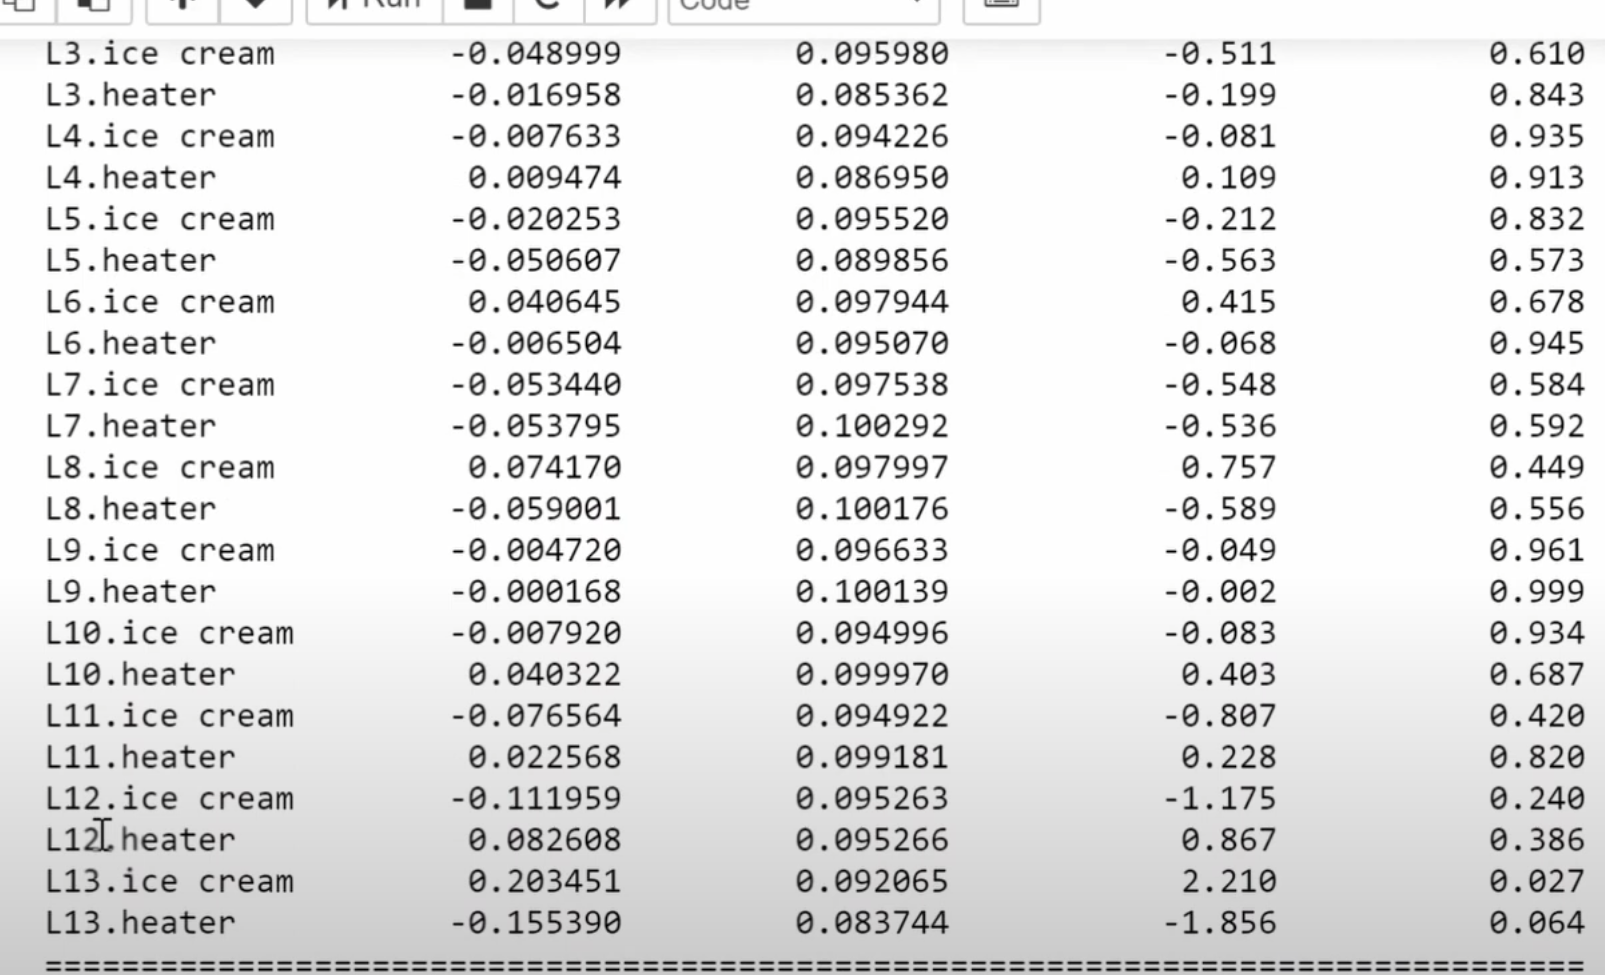

In [29]:
Image('images\\91.png')

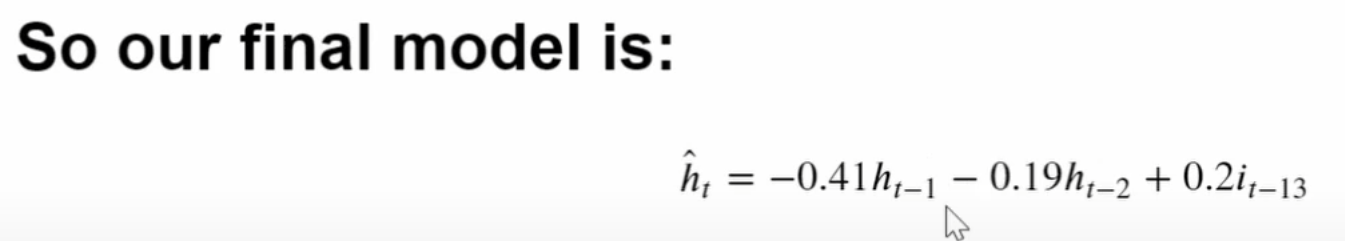

In [30]:
Image('images\\92.png')

Residual normality test

In [31]:
def adjust(val, length= 6): return str(val).ljust(length)

from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)
for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

rgnp   : 2.09
pgnp   : 2.02
ulc    : 2.17
gdfco  : 2.05
gdf    : 2.25
gdfim  : 1.99
gdfcf  : 2.2
gdfce  : 2.17


In [32]:
# """
# 12. Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
# Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors).

# What does this mean to us?

# If there is any correlation left in the residuals, then, 
# there is some pattern in the time series that is still left to be explained by the model. 
# In that case, the typical course of action is to either increase the order of the model or induce more predictors 
# into the system or look for a different algorithm to model the time series.

# So, checking for serial correlation is to ensure that the model is sufficiently 
# able to explain the variances and patterns in the time series.

# Alright, coming back to topic.

# A common way of checking for serial correlation of errors can be measured using the Durbin Watson’s Statistic.

# The value of this statistic can vary between 0 and 4. 
# The closer it is to the value 2, then there is no significant serial correlation. 
# The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.
# The serial correlation seems quite alright. Let’s proceed with the forecast.
# """

forecasting

In [33]:
# 13. How to Forecast VAR model using statsmodels
# In order to forecast, the VAR model expects up to the lag order number of observations from the past data.

# This is because, the terms in the VAR model are essentially the lags of the various time series in the dataset, 
# so you need to provide it as many of the previous values as indicated by the lag order used by the model.

In [34]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

4


array([[ 13.5,   0.1,   1.4,   0.1,   0.1,  -0.1,   0.4,  -2. ],
       [-23.6,   0.2,  -2. ,  -0.5,  -0.1,  -0.2,  -0.3,  -1.2],
       [ -3.3,   0.1,   3.1,   0.5,   0.3,   0.4,   0.9,   2.2],
       [ -3.9,   0.2,  -2.1,  -0.4,   0.2,  -1.5,   0.9,  -0.3]])

In [35]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,rgnp_2d,pgnp_2d,ulc_2d,gdfco_2d,gdf_2d,gdfim_2d,gdfcf_2d,gdfce_2d
date,,,,,,,,
1988-10-01,48.322456,1.250774,0.595993,0.265657,-0.104146,0.304119,-0.917227,-0.113061
1989-01-01,-34.962286,-0.387966,-0.329877,-0.042217,0.164633,1.357223,0.618163,3.029975
1989-04-01,20.392680,0.291298,0.390812,-0.134488,-0.486073,-0.149551,-1.238234,-2.345223
1989-07-01,-37.416599,-0.280943,0.367912,0.102797,0.333371,-0.502103,0.469468,0.517424


In [36]:
df_test

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1988-10-01,4069.4,3995.8,181.3,133.3,126.2,107.3,124.9,92.9
1989-01-01,4106.8,4019.9,184.1,134.8,127.7,109.5,126.6,94.0
1989-04-01,4132.5,4044.1,186.1,134.8,129.3,111.1,129.0,100.6
1989-07-01,4162.9,4068.4,187.4,137.2,130.2,109.8,129.9,98.2


In [37]:
# The forecasts are generated but it is on the scale of the training data used by the model. 
# So, to bring it back up to its original scale, you need to de-difference it as many times you had differenced
# the original input data.

# In this case it is two times.

Un-differencing (invert the transformation to get the real forcast)

In [38]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [39]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['rgnp_forecast', 'pgnp_forecast', 'ulc_forecast', 'gdfco_forecast',
                   'gdf_forecast', 'gdfim_forecast', 'gdfcf_forecast', 'gdfce_forecast']]

,rgnp_forecast,pgnp_forecast,ulc_forecast,gdfco_forecast,gdf_forecast,gdfim_forecast,gdfcf_forecast,gdfce_forecast
date,,,,,,,,
1988-10-01,4123.022456,3996.950774,181.095993,132.965657,126.395854,106.604119,125.082773,93.186939
1989-01-01,4168.382626,4021.613582,182.262108,134.389097,128.056341,108.365461,127.283708,96.603854
1989-04-01,4234.135476,4046.567687,183.819036,135.678050,129.230756,109.977252,128.246409,97.675545
1989-07-01,4262.471728,4071.240850,185.743875,137.069799,130.738542,111.086940,129.678579,99.264661


plot of forcast vs actuals

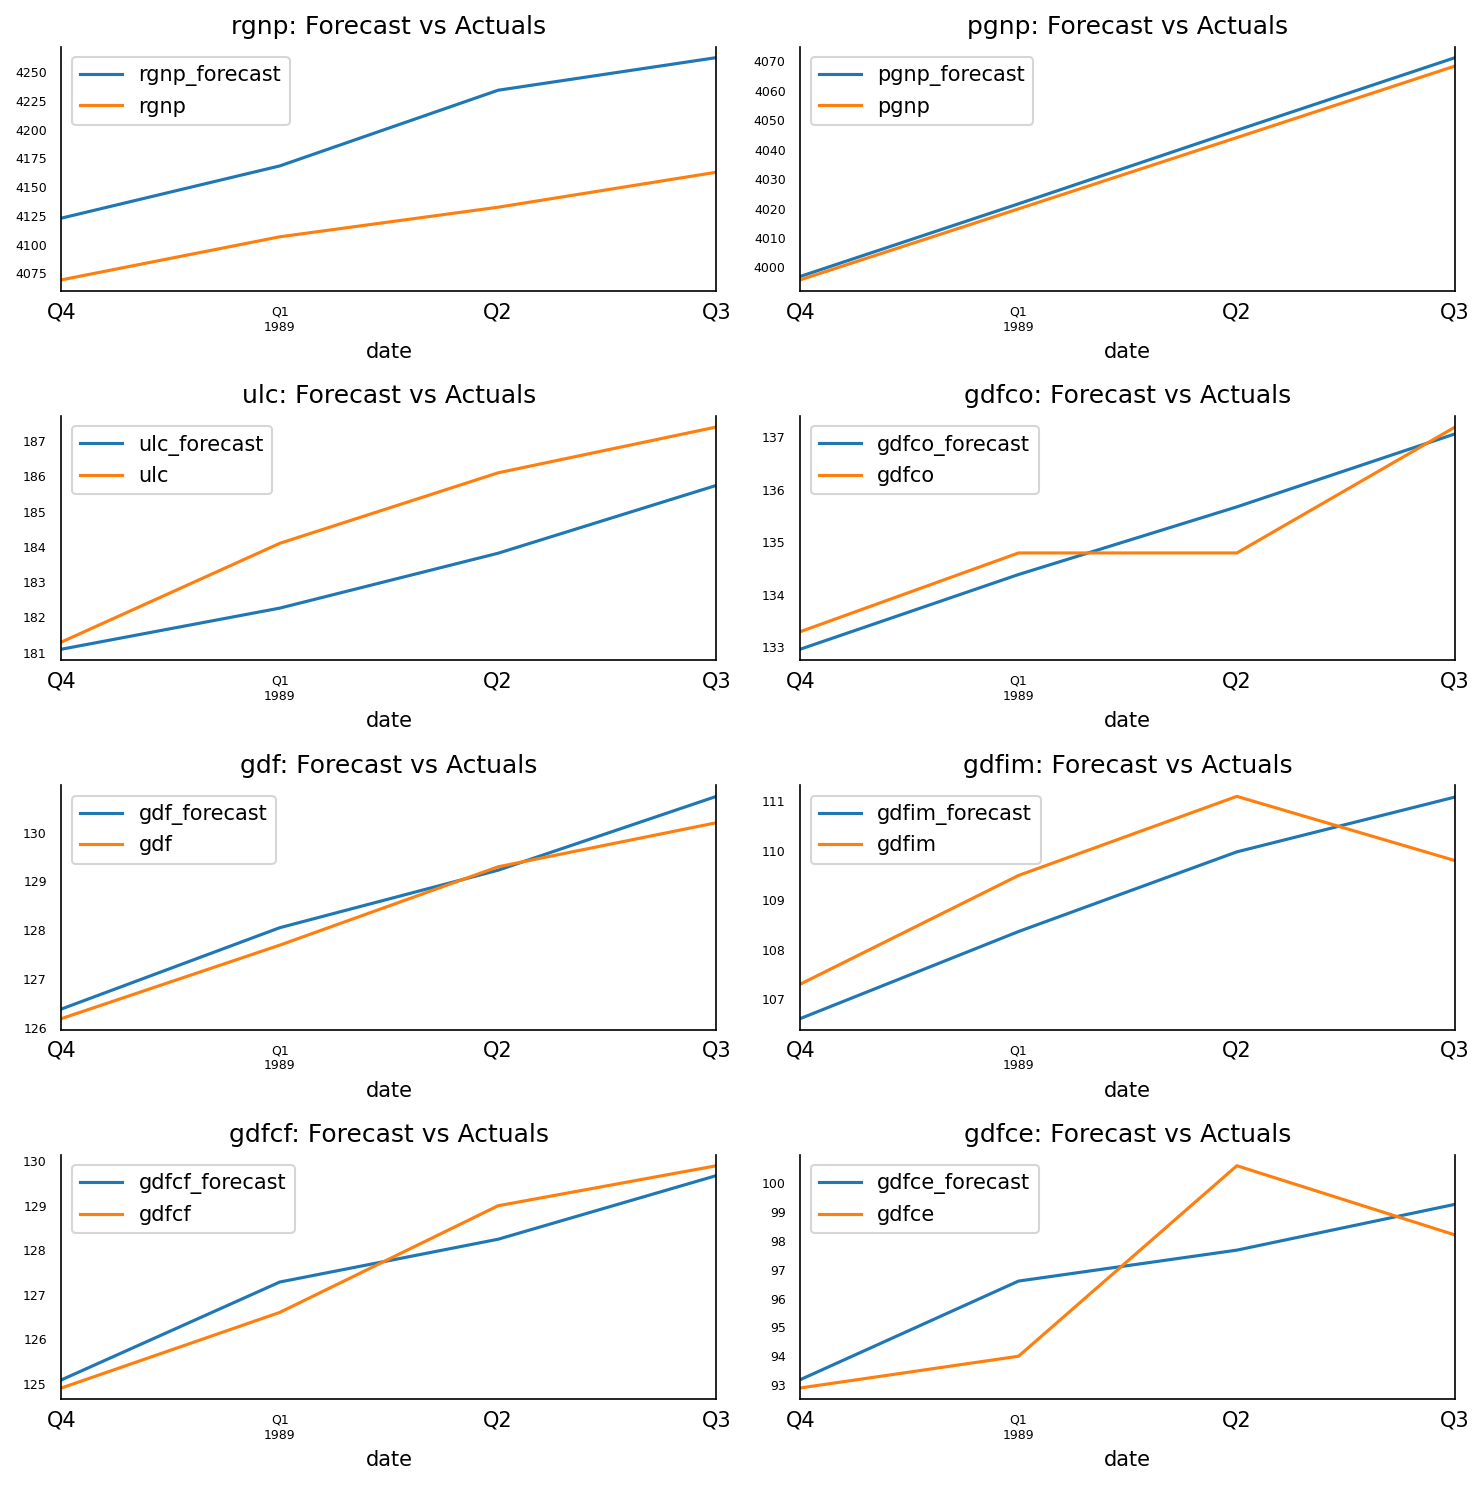

In [40]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

<AxesSubplot: xlabel='date'>

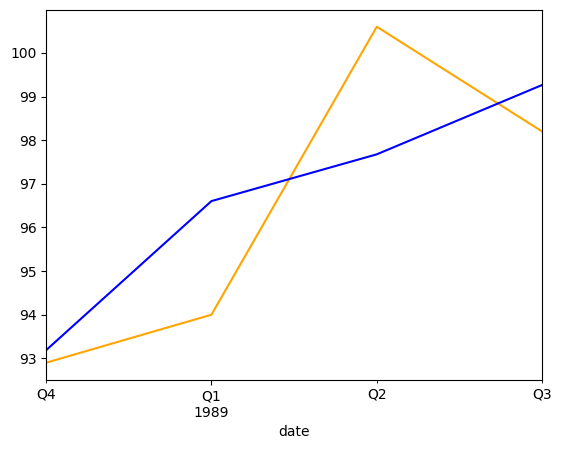

In [41]:
df_test['gdfce'].plot(color='orange')
df_results['gdfce_forecast'].plot(color='blue')

evaluation of the forecasts

In [42]:
# To evaluate the forecasts, 
# let’s compute a comprehensive set of metrics, namely, the MAPE, ME, MAE, MPE, RMSE, corr and minmax.

In [43]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: rgnp')
accuracy_prod = forecast_accuracy(df_results['rgnp_forecast'].values, df_test['rgnp'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: pgnp')
accuracy_prod = forecast_accuracy(df_results['pgnp_forecast'].values, df_test['pgnp'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: ulc')
accuracy_prod = forecast_accuracy(df_results['ulc_forecast'].values, df_test['ulc'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfco')
accuracy_prod = forecast_accuracy(df_results['gdfco_forecast'].values, df_test['gdfco'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdf')
accuracy_prod = forecast_accuracy(df_results['gdf_forecast'].values, df_test['gdf'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfim')
accuracy_prod = forecast_accuracy(df_results['gdfim_forecast'].values, df_test['gdfim'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfcf')
accuracy_prod = forecast_accuracy(df_results['gdfcf_forecast'].values, df_test['gdfcf'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfce')
accuracy_prod = forecast_accuracy(df_results['gdfce_forecast'].values, df_test['gdfce'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: rgnp
mape   :  0.0192
me     :  79.1031
mae    :  79.1031
mpe    :  0.0192
rmse   :  82.0245
corr   :  0.9849
minmax :  0.0188

Forecast Accuracy of: pgnp
mape   :  0.0005
me     :  2.0432
mae    :  2.0432
mpe    :  0.0005
rmse   :  2.146
corr   :  1.0
minmax :  0.0005

Forecast Accuracy of: ulc
mape   :  0.0081
me     :  -1.4947
mae    :  1.4947
mpe    :  -0.0081
rmse   :  1.6856
corr   :  0.963
minmax :  0.0081

Forecast Accuracy of: gdfco
mape   :  0.0033
me     :  0.0007
mae    :  0.4384
mpe    :  0.0
rmse   :  0.5169
corr   :  0.9407
minmax :  0.0032

Forecast Accuracy of: gdf
mape   :  0.0023
me     :  0.2554
mae    :  0.29
mpe    :  0.002
rmse   :  0.3392
corr   :  0.9905
minmax :  0.0022

Forecast Accuracy of: gdfim
mape   :  0.0097
me     :  -0.4166
mae    :  1.06
mpe    :  -0.0038
rmse   :  1.0826
corr   :  0.807
minmax :  0.0096

Forecast Accuracy of: gdfcf
mape   :  0.0036
me     :  -0.0271
mae    :  0.4604
mpe    :  -0.0002
rmse   :  0.5286
corr   :  

C:\Users\SH\AppData\Local\Temp\ipykernel_21908\3502259533.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\SH\AppData\Local\Temp\ipykernel_21908\3502259533.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


충격반응분석

# VAR 모형 순서 바꾸는거 IRF에서 할 수 있음 (but not implemented yet in statsmodels)

In [44]:
# see how a variable will behave in N-periods from now if I shock the variables inside the system.
# rgnp의 shock (impulse)이 pgnp (response)에 얼마나 영향을 미치는지
# shock rgnp and see the response of pgnp to the shock on rgnp

## econometrics6 pg. 52 <br>
## 차분자료 이용시 변수들간 장기균형관계 측정 불가 <br>
## 특히 IRA 실시해보면, 차분자료로 IRA 할경우 IRF가 다음과 같은 형태로 진동하는 형태로 나옴
## This is why VECM model is necessary

In [45]:
# model_fitted.irf(var_order = ['rgnp', 'pgnp'])

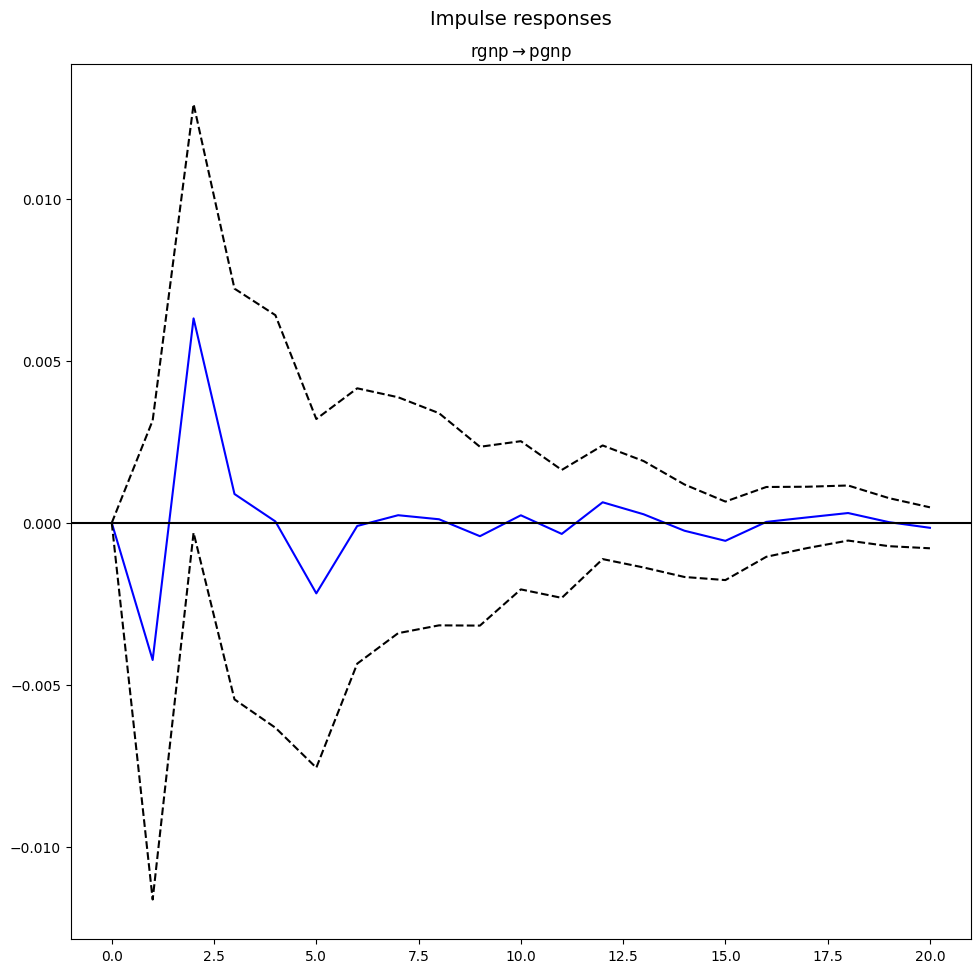

In [46]:
irf = model_fitted.irf(periods=20)
irf.plot(impulse = 'rgnp', response='pgnp')
plt.show()

In [47]:
# this is the response of pgnp if we increase rgnp
# notice that in 1st period it will decrease pgnp
# 점선으로 된 부분은 confidence interval

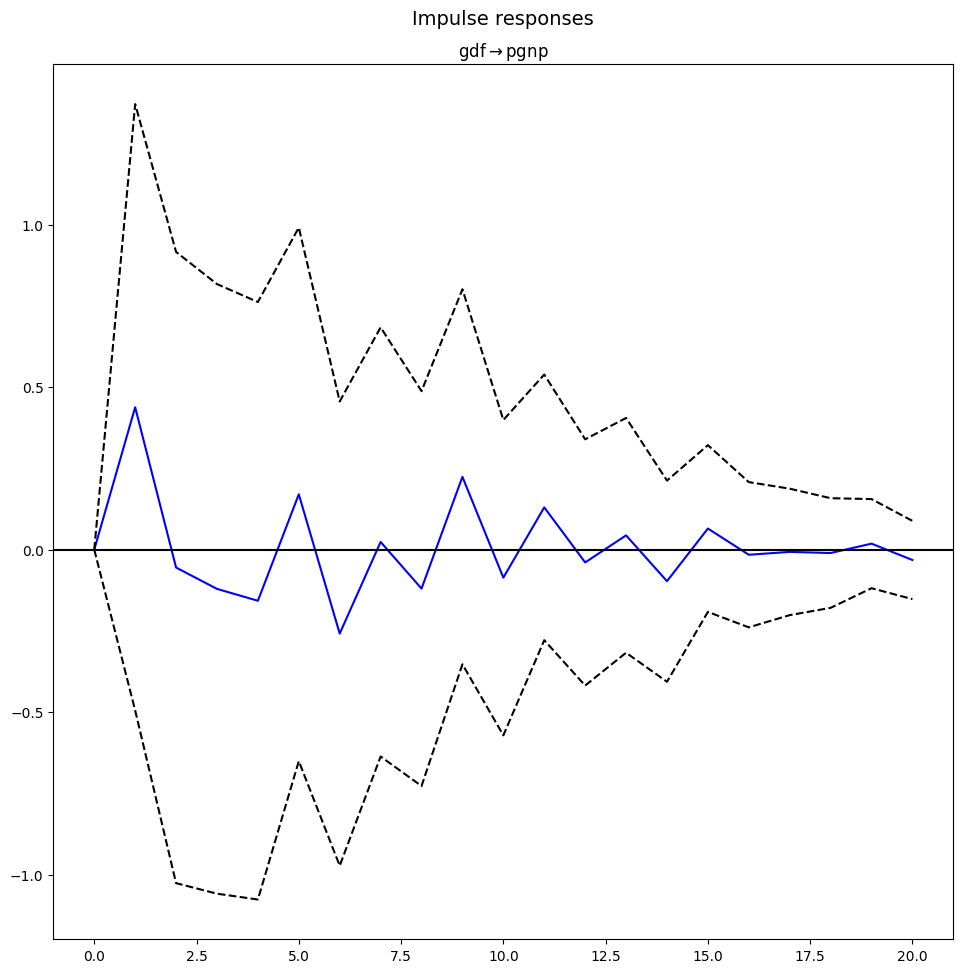

In [48]:
irf = model_fitted.irf(periods=20)
irf.plot(impulse = 'gdf', response='pgnp')
plt.show()

Variance Decomposition

how much these variables are influenced by shocks

In [55]:
temp_model = smt.VAR(df_differenced[['rgnp', 'ulc', 'gdf']])
result = temp_model.fit(maxlags=4, method='mle')

c:\Users\SH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [56]:
fevd1 = result.fevd(periods=11)

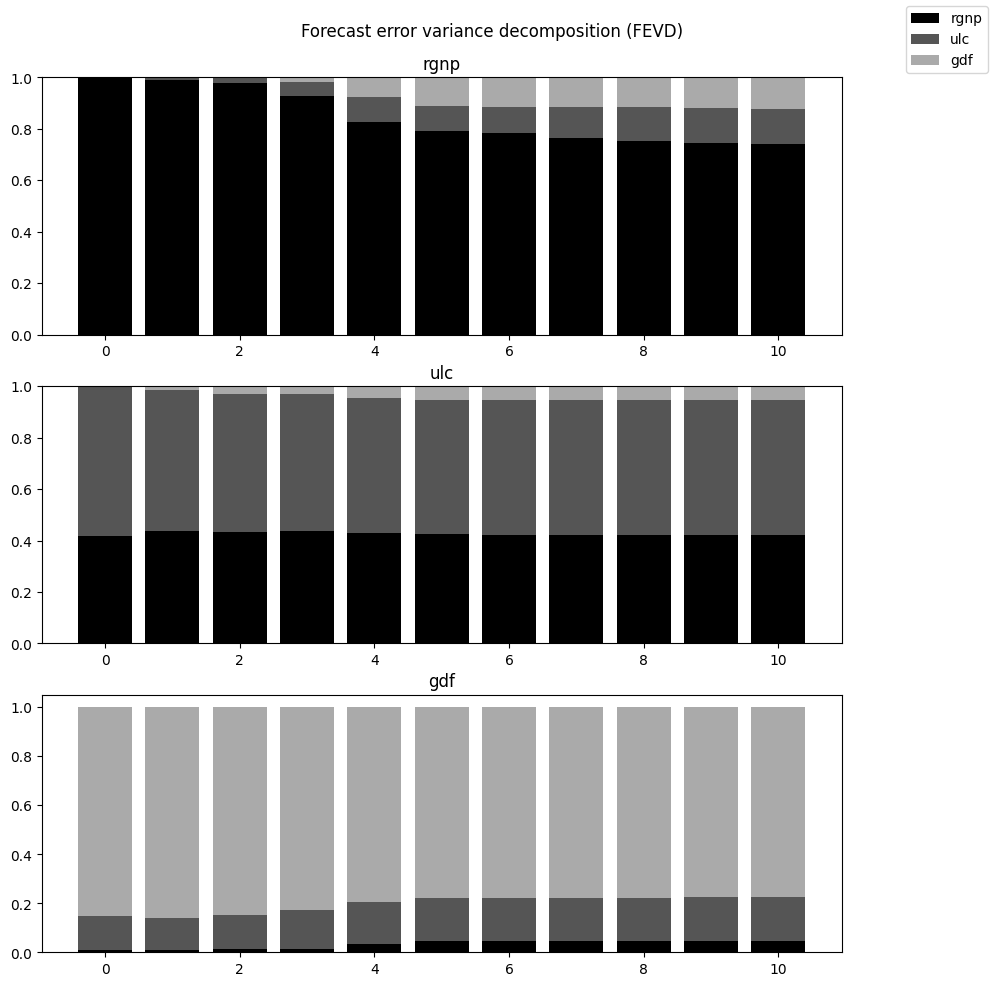

In [57]:
fevd1.plot()
plt.show()

In [ ]:
# 해석:
# rgnp is relatively influenced by its own shock
# 1st period ahead, almost entire change in rgnp will almost be due to rgnp
# and for periods ahead, there are some proportions of ulc and gdf, but very minimal